# Example iDDC analysis with spaceprime

In [1]:
import importlib
import msprime
import tskit
import spaceprime as sp
from spaceprime import analysis
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


importlib.reload(sp)

<module 'spaceprime' from '/Users/connorfrench/Dropbox/Old_Mac/software-dev/spaceprime/spaceprime/__init__.py'>

## Import data

Read in projections of *Phyllomedusa distincta* species distribution
model. The projections are in 1000 year increments from present-day to
22 kya. The resolution of the data is 0.083 degrees, which corresponds
with 5 arc-minutes, or approximately 10 km<sup>2</sup> at the equator.

In [2]:
proj_path = "../sdm/output/projections.tif"
projections = rasterio.open(proj_path)

projections.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 116,
 'height': 119,
 'count': 23,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.08333333300000001, 0.0, -54.16680605885,
        0.0, -0.08333333300000001, -21.666805828849988)}

A quick plot shows the first projection, which is the predicted
present-day distribution of the species.

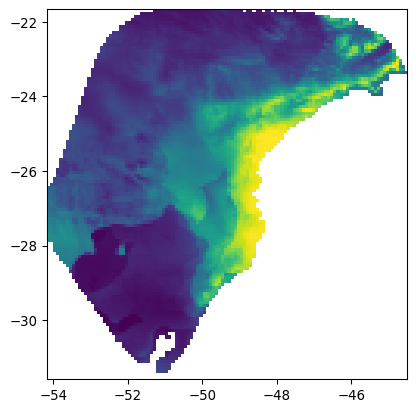

In [3]:
show((projections, 1))
plt.show()

Read in the data file that contains longitude and latitude coordinates
for sampling localities and the individual names.

In [4]:
locs_path = "../sdm/distincta_localities_ex.geojson"
locs = gpd.read_file(locs_path)

locs.head()

If your data is in a different, text-based format like CSV, you can
convert it to a geopandas dataframe.

In [5]:
locs = pd.read_csv("../sdm/distincta_localities_ex.csv")
locs = gpd.GeoDataFrame(locs, geometry=gpd.points_from_xy(locs.longitude, locs.latitude))

Let’s plot the localities on top of the projection to make sure
everything looks good.

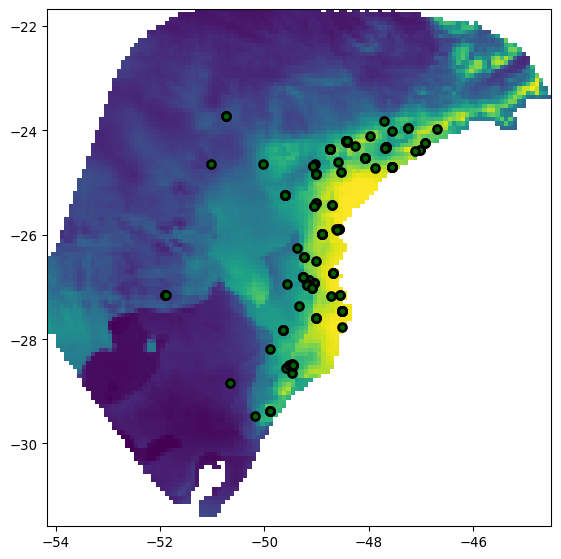

In [6]:
# plot the projection with the localities overlaid
fig, ax = plt.subplots(figsize=(7, 7))
show(projections, ax=ax)
locs.plot(ax=ax, facecolor='darkgreen', edgecolor='black', linewidth=2)

plt.show()

## Transform SDM

Now it’s time to transform the SDM into deme sizes. For this example,
let’s use a linear transformation with a maximum local deme size of
1000, and mask out any cells that have a suitability lower than the
minimum training presence suitability.

In [7]:
# get the minimum threshold from the localities
mpt = sp.mtp_thresh_from_coords(projections, locs)

# transform the SDM
demes = sp.raster_to_demes(projections, transformation="linear", max_local_size=1000, threshold=mpt)

Let’s plot the demes to make sure the transformation went according to
plan. Demes which were formerly `nan` are now a very small number
(1e-10) to accommodate fluctuations in suitability through time. Also
notice that the axis labels are different- the object that is returned
by `raster_to_demes()` is a `np.ndarray`, without the raster metadata
supplied by `rasterio`. To convert the output to a raster for
visualization in GIS software, you can use the `create_raster()`
function.

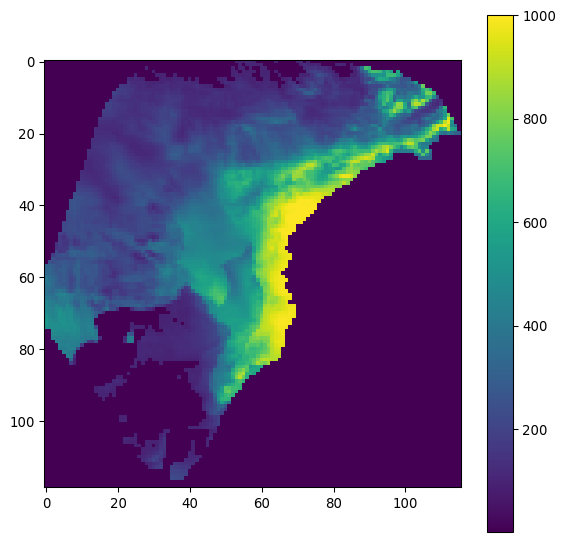

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(demes[0], cmap='viridis')
plt.colorbar(im)

plt.show()

## Setup demography

### Define ancestral populations

*P. distincta* have two populations with deep divergence (~0.61 mya)
according to (Brunes et al. 2015). The samples are assigned to one of
two ancestral populations according to these population assignments. In
order to recapitulate this genetic structure across the landscape, the
sample ancestral population assignments are interpolated using a nearest
neighbors algorithm. Each deme on the landscape will then merge into its
respective ancestral population at a designated time in the past. The
function `split_landscape_by_pop()` returns a numpy array with the
population assignments for each deme, which will be used in setting up
the demography object.

> Note: there are some samples in this example data set that were not
> present in Brunes et al. (2015). These samples were assigned to the
> population with the most nearby samples.

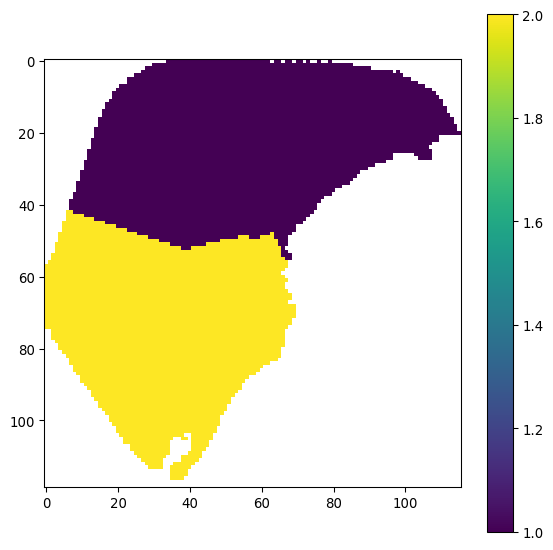

In [9]:
anc_pop_assignments = sp.split_landscape_by_pop(projections, locs, locs.anc_pop_id.to_list(), mask_rast = True)

# plot the population assignments
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(anc_pop_assignments, cmap='viridis')
plt.colorbar(im) 
plt.show()

For visualization purposes, we set `mask_rast = True` to mask out the
assignment to the landscape, but for parameterizing the model, the full
extent of the raster should be used. So we will set `mask_rast = False`
in the next step.

In [10]:
anc_pop_assignments = sp.split_landscape_by_pop(projections, locs, locs.anc_pop_id.to_list(), mask_rast = False)

### Setup spatial demography

The first step of setting up the demography involves translating the
local deme sizes array into an `msprime Demography` object and assign
migration rates. The global migration rate is scaled locally by the
donor and recipient deme sizes when `scale=True`. Generation times are
in units of generations, so the time passing between each projected SDM
must be translated into numbers of generations for your organism. We
will assume a generation time of 1 year, following Brunes et al. (2015).
Migration will be set at 0.001.

It may take a minute or so for the model to get set up for a large
landscape and many time steps like this one.

In [11]:
d = sp.stepping_stone_2d(demes, rate=0.001, scale=True, timestep=1000)

The number of demographic events (changes in deme size or migration
rate) through time can be quite large- for this model there are 13,807
demes and 487,338 demographic events. While `msprime` has a
`DemographyDebugger` class that is quite useful for debugging, it was
designed for smaller models and is prohibitively slow for large models
like this one.

### Add ancestral populations

After a certain number of generations, space becomes less important in
describing the contemporary genetic diversity and the added
computational burden of a spatial model may not be worth it. To account
for this, we will merge the demes into ancestral populations at a
certain time in the past. Using `add_ancestral_pops()`, you have the
option to merge all demes into a single population, or to merge them
into their respective ancestral populations. The ancestral populations
can exchange migrants and can also merge into a single population at a
later time.

We have spatially-explicit SDMs going back to 22 kya, so we will merge
the demes into their respective ancestral populations 1000 years before
that (23 kya). Also, according to Brunes et al. (2015), the two
populations of *P. distincta* exhanged migrants and diverged around 0.61
mya, so we will add migration between the two ancestral populations and
merge them at 0.61 mya (610,000 generations). Additionally, the
ancestral *Ne* was estimated to be ~260,000 individuals and the merged
population *Ne* was estimated ~900,000, so we will set the ancestral
population sizes and merged population size to these values.

In [12]:
d = sp.add_ancestral_populations(
  d, 
  anc_sizes=[2.6e5, 2.6e5], 
  merge_time=23000, 
  anc_id=anc_pop_assignments, 
  anc_merge_sizes=[9e5], 
  anc_merge_times=[6.1e5], 
  migration_rate=0.001
  )

## Perform coalescent simulation

Simulations are performed in two phases- the first to simulate the
coalescent histories and the second to simulate the mutations.

Prior to running simulations, the deme indices that correspond with
empirical samples must be specified as a dictionary, where the keys are
the deme indices, and the values are the number of samples from that
deme. This is accomplished with the `coords_to_sample_dict()` function,
which determines the number of samples from each deme based on the
number of sample coordinates that overlap a particular deme.

The function returns a tuple containing two dictionaries and an optional
third dictionary. The first is the sample dictionary, which is required
for simulations, while the second maps the deme indices to indices
representing individuals in the output tree sequence, which is useful
for analysis. The optional third dictionary maps the deme indices to
empirical sample names, which is useful for calculating comparable
genetic summary statistics from the empirical data.

In [13]:
sample_dict, deme_dict, _ = sp.coords_to_sample_dict(projections, locs)

The `sample_dict` is then passed to the `msprime.sim_ancestry()`
function to simulate the coalescent histories. The `sequence_length`
parameter is the length of the sequence in base pairs, and the
`recombination_rate` parameter is the rate of recombination per base
pair per generation. The `random_seed` parameter is used to set the
random seed for reproducibility. The full suite of parameters for
`msprime.sim_ancestry()` can be found in the [msprime
documentation](https://msprime.readthedocs.io/en/stable/api.html#msprime.sim_ancestry).
Note- for simulations of a similar size to this one, it’s always a good
idea to set `record_provenance=False` to save on memory.

For a simulation of this size, it may take a few minutes to run.

In [14]:
ts = msprime.sim_ancestry(
  demography=d, 
  samples=sample_dict, 
  sequence_length=1e6, 
  recombination_rate=1e-9, 
  random_seed=43,
  record_provenance=False
  )

The `ts` object is then passed to `msprime.sim_mutations()` to simulate
mutations on the coalescent histories. The `mutation_rate` parameter is
the rate of mutation per base pair per generation. The full suite of
parameters for `msprime.sim_mutations()` can be found in the [msprime
documentation](https://msprime.readthedocs.io/en/stable/api.html#msprime.sim_mutations).

In [15]:
ts = msprime.sim_mutations(
  ts, 
  rate=1e-8, 
  random_seed=99
  )

## Calculate summary statistics

The first step in calculating summary statistics is to convert sampling
coordinates to a dictionary that maps the deme indices to the
coordinates of the demes. These coordinates are used for calculating
spatial summary statistics like isolation-by-distance (IBD) and Moran’s
I. This is accomplished with the `coords_to_deme_dict()` function. The
second step is to convert the ancestral population assignments to a
dictionary that maps the deme indices to the ancestral population
assignments. This dictionary is used to map demes to their ancestral
populations so within- and between-population summary statistics can be
calculated. This is accomplished with the `anc_to_deme_dict()` function.

In [18]:
coords_dict = sp.coords_to_deme_dict(projections, locs)
anc_demes_dict = sp.anc_to_deme_dict(anc_pop_assignments, deme_dict)

The next step involves filtering your data to reasonably represent and
empirical genotype matrix, with `analysis.filter_gt()`. Prior to
executing the function, convert the tree sequence into a genotype matrix
with the `msprime` function `ts.genotype_matrix()`. The function returns
the filtered genotype matrix, an allele counts array for the filtered
samples, a dictionary of allele counts arrays for the demes, and a
dictionary of allele counts matrices for the ancestral populations.
These are all fancy arrays for use in the powerful population genetics
package `scikit-allel`. We’re using the default filtering parameters
here, but you can adjust them as needed.

In [19]:
gt = ts.genotype_matrix()
gt_filt, ac_filt, ac_demes, ac_anc = analysis.filter_gt(gt, deme_dict_inds=deme_dict, deme_dict_anc=anc_demes_dict)

Now to calculate the summary statistics! This is a convenience function
for calculating a suite of spatial (IBD, Moran’s I) and non-spatial (π,
Tajima’s D, site-frequency-spectrum (SFS) summarize by the first two
Hill numbers, F<sub>ST</sub>, *D<sub>xy</sub>*) The function returns a
dictionary of summary statistics, which can be converted to a pandas
dataframe with the `return_df=True` parameter. A full description of
genetic summary statistics for `calc_sumstats()` can be found in the
[spaceprime documentation](https://connor-french.github.io/spaceprime/).

In [20]:
stats = analysis.calc_sumstats(ac_filt, coords_dict=coords_dict, anc_demes_dict=anc_demes_dict, ac_demes=ac_demes, ac_anc=ac_anc, return_df=True)

stats

1 rows × 919 columns

## References

Brunes, Tuliana O, Maria Tereza C Thomé, João Alexandrino, Célio F B
Haddad, and Fernando Sequeira. 2015. “Ancient Divergence and Recent
Population Expansion in a Leaf Frog Endemic to the Southern Brazilian
Atlantic Forest.” *Org. Divers. Evol.* 15 (4): 695–710.
<https://doi.org/10.1007/s13127-015-0228-4>.